In [49]:
import pandas as pd
import datetime
import time
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [2]:
def get_data(pair, t_start, t_stop, bin_size):
    time_step = 60000000
    limit = 1000
    df = {}
    path = f'./data/{pair}_{t_start}-{t_stop}_{bin_size}.csv'
    if (os.path.exists(path)) and (os.path.isfile(path)):
        df = pd.read_csv(path, index_col=0)
    else:
        data = fetch_data(start=t_start, stop=t_stop, symbol=pair, interval=bin_size, tick_limit=limit, step=time_step)
        names = ['time', 'open', 'close', 'high', 'low', 'volume']
        df = pd.DataFrame(data, columns=names)
        df.drop_duplicates(inplace=True)
        df['time'] = pd.to_datetime(df['time'], unit='ms')
        df.set_index('time', inplace=True)
        df.sort_index(inplace=True)
        print(df.head())
        df.to_csv(f'./data/{pair}_{t_start}-{t_stop}_{bin_size}.csv')
    return df

In [96]:
t_start = datetime.datetime(2019, 1, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

t_stop = datetime.datetime(2019, 12, 1, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

dataset = get_data(pair='btcusd', t_start=t_start, t_stop=t_stop, bin_size='12h')
dataset.head()

NameError: name 'fetch_data' is not defined

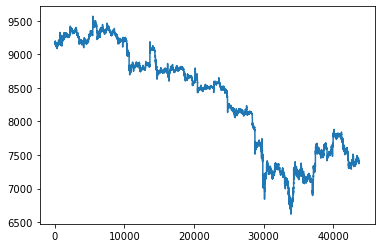

In [11]:
plt.plot(dataset['open'].to_numpy())
plt.show()

In [12]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 

In [72]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size].copy(), dataset.iloc[train_size:len(dataset)].copy()
print(len(train), len(test))

f_columns = ['open', 'close', 'high', 'low']

f_transformer = MinMaxScaler()
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)
test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

v_columns = ['volume']

v_transformer = RobustScaler()
v_transformer = v_transformer.fit(train[v_columns].to_numpy())
train.loc[:, v_columns] = v_transformer.transform(
  train[v_columns].to_numpy()
)
test.loc[:, v_columns] = v_transformer.transform(
  test[v_columns].to_numpy()
)


train = train.to_numpy()
test = test.to_numpy()

35006 8752


In [85]:
#test_inv = f_transformer.inverse_transform(test[:,:4])
#test_inv[1]
test_inv_v = v_transformer.inverse_transform(test[:,4:])
test_inv_v

array([[ 0.71485455],
       [ 0.68887995],
       [ 0.18392432],
       ...,
       [30.94050624],
       [ 4.53644852],
       [ 0.3440442 ]])

In [87]:
# choose a number of time steps
n_steps_in, n_steps_out = 30, 10
# covert into input/output
X, y = split_sequences(train, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

In [95]:
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

In [93]:
# fit model
history = model.fit(X, y,
          epochs=40,
          batch_size=256,
          validation_split=0.2),
          shuffle=True)


ValueError: Error when checking target: expected dense_5 to have 2 dimensions, but got array with shape (34917, 10, 5)

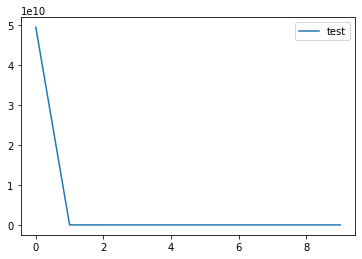

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()


In [25]:
X_val, y_val = split_sequences(test, n_steps_in, n_steps_out)
X_val = X_val.reshape((X_val.shape[0], n_steps_in, n_features))
# demonstrate prediction
yhat = model.predict(X_val)

In [ ]:
#y_inv = f_transformer.inverse_transform(y.reshape(1, -1))
#y_val_inv = f_transformer.inverse_transform(y_val.reshape(5, -1))
#print(yhat.shape)
y_hat_inv = f_transformer.inverse_transform(yhat[0])
y_val_inv = f_transformer.inverse_transform(y_val[0])


In [ ]:
yhat.shape

In [30]:
def plot_predictions(X,y, yhat):
    x_data = range(90)
    for i in range(1):#X.shape[0]):
        X_inv = f_transformer.inverse_transform(X[i])
        y_inv = f_transformer.inverse_transform(y[i])
        
        yhat_inv = f_transformer.inverse_transform(yhat[i])
        print(yhat_inv.shape)
        for j in range(5):
            plt.plot(x_data[:80], X_inv[:,j], label=f'history open {j}')
            plt.plot(x_data[80:], y_inv[:,j], label=f'true vals {j}')
            plt.plot(x_data[80:], yhat_inv[:,j], label=f'pred vals {j}')
            plt.legend()
            plt.show()

(10, 5)


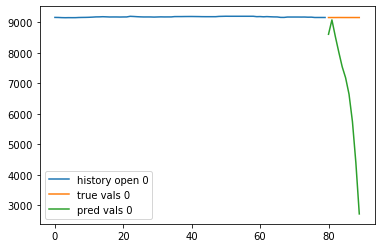

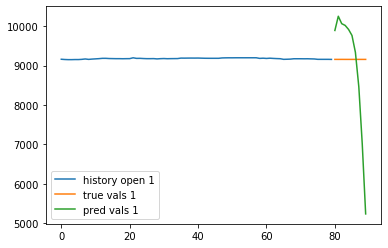

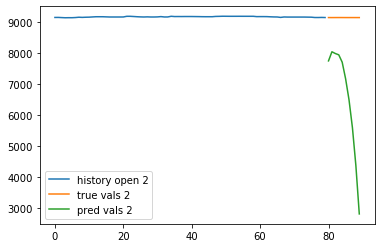

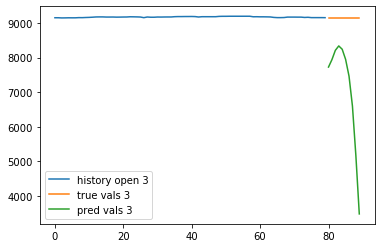

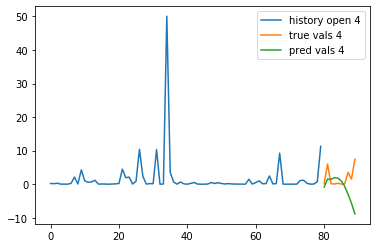

In [31]:
plot_predictions(X,y, yhat)

In [ ]:
print(X_val.shape)
print('prediction shape:',yhat.shape)

print('true values shape:', y_val.shape)

y_val[0]


In [ ]:
res = y_val_inv.reshape(5,-1)
res.shape
res[0]

In [ ]:
plt.plot(y_hat_inv[3], label='pred')
plt.plot(y_val_inv[3], label='true')
plt.legend()